<img src="https://www.cecodes.org.co/site/wp-content/uploads/2016/01/WP_asociado_COLSUBSIDIO-832x350.jpg" alt="Logo Colsubsidio" width=200>

# Modelo de retención de Crédito

## Importación de paquetes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Cargue de datos

In [2]:
data = pd.read_csv("../BD/Resultados/data.csv")
data.head(3)

,identificacion,tarjeta,fecha_expedicion,intento,fecha_proceso,disponible_avances,limite_avances,total_intereses,saldos_mes_ant,pagos_mes_ant,vtas_mes_ant,edad_mora,limite_cupo,pago_del_mes,pago_minimo,vr_mora,vr_cuota_manejo,saldo,dias_intencion
0,37555209,61,2006-11-03,0,2018-04-01,1476000.0,1476000.0,0.0,0.0,0.0,0.0,0,3690000.0,0.0,0.0,0.0,0.0,0.0,4167
1,52270584,103,2006-11-03,0,2018-04-01,300000.0,300000.0,0.0,0.0,0.0,0.0,0,1000000.0,0.0,0.0,0.0,0.0,0.0,4167
2,51583980,269,2006-11-04,0,2018-04-01,1050000.0,1050000.0,0.0,0.0,0.0,0.0,0,2625000.0,0.0,0.0,0.0,0.0,0.0,4166


## Partición de Datos

In [3]:
data.columns

Index(['identificacion', 'tarjeta', 'fecha_expedicion', 'intento',
       'fecha_proceso', 'disponible_avances', 'limite_avances',
       'total_intereses', 'saldos_mes_ant', 'pagos_mes_ant', 'vtas_mes_ant',
       'edad_mora', 'limite_cupo', 'pago_del_mes', 'pago_minimo', 'vr_mora',
       'vr_cuota_manejo', 'saldo', 'dias_intencion'],
      dtype='object')

In [4]:
features=['disponible_avances', 'limite_avances','total_intereses', 'saldos_mes_ant', 'pagos_mes_ant', 'vtas_mes_ant',
          'edad_mora', 'limite_cupo', 'pago_del_mes', 'pago_minimo', 'vr_mora','vr_cuota_manejo', 'saldo','dias_intencion']
X = data[features]
y = data['intento']

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =train_test_split(X,y,test_size=0.3,random_state=31415)

In [6]:
print(X.shape, x_train.shape, x_test.shape)

(732036, 14) (512425, 14) (219611, 14)


## Valores Ausentes

In [7]:
x_train.apply(lambda x: x.isnull().sum(), axis=0)
x_train.apply(lambda x: x.fillna(x.mean(), inplace=True))

disponible_avances    None
limite_avances        None
total_intereses       None
saldos_mes_ant        None
pagos_mes_ant         None
vtas_mes_ant          None
edad_mora             None
limite_cupo           None
pago_del_mes          None
pago_minimo           None
vr_mora               None
vr_cuota_manejo       None
saldo                 None
dias_intencion        None
dtype: object

## Balanceo de Muestra

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
sm = SMOTE(ratio=0.5, random_state=31415)
X_res, y_res = sm.fit_sample(x_train, y_train)

C:\Users\hernyatt\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
print(X_res.shape, y_res.shape)

(746566, 14) (746566,)


In [12]:
y_res.mean()

0.33333288684456563

## Estimación del modelo

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


models = {'lr': LogisticRegression()
          #,'dt': DecisionTreeClassifier()
          ,'rf': RandomForestClassifier(random_state=31415, n_jobs=-1, n_estimators=1000)
          #,'gb': GradientBoostingClassifier(random_state=31415)
          #,'ab': AdaBoostClassifier(random_state=31415)
         }

In [20]:
for model in models.keys():
    models[model].fit(X_res, y_res)

In [24]:
y_pred = pd.DataFrame(index=x_test.index, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(x_test)

In [25]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score

for model in models.keys():
    print(model,'accuracy',accuracy_score(y_test,y_pred[model]))
    print(model,'ROC',roc_auc_score(y_test,y_pred[model]))    
    print(model,'precision',precision_score(y_test,y_pred[model]))
    print(model,'recall',recall_score(y_test,y_pred[model]))
    print(model,'f1 score', f1_score(y_test,y_pred[model]))

lr accuracy 0.9264927530952457
lr ROC 0.6072362396722738
lr precision 0.12593262491521592
lr recall 0.2688223938223938
lr f1 score 0.17151655119322554
rf accuracy 0.9647057752116242
rf ROC 0.8544667013483644
rf precision 0.42830453059318074
rf recall 0.7376126126126126
rf f1 score 0.5419301459724603


Se selecional el random Forest para predecir la probabilidad de fuga de los clientes.

### Almacenamiento del Modelo Final

In [27]:
FinalMod=models['rf']
from sklearn.externals import joblib
joblib.dump(FinalMod, '../Resultados/ModeloRetencion.pkl')

['../Resultados/ModeloRetencion.pkl']

## Random Forest

Text(0.5,0,'Importancia Relativa')

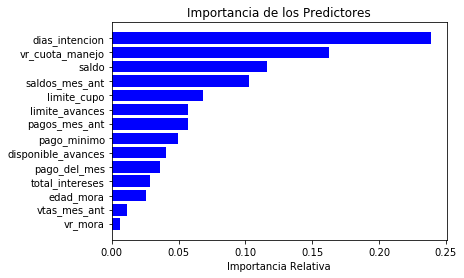

In [28]:
# Almacenamiento de la importancia de los predictores.
importances = models['rf'].feature_importances_
indices = np.argsort(importances)

# Gráfico de importancia de los predictores.
plt.figure(1)
plt.title('Importancia de los Predictores')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importancia Relativa')